In [1]:
import os.path, gym
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import roboschool
import pdb
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
GAMMA = .95
from functools import partial
NUM_HISTORY = 6
TESTING_GRAD_NORMS = 1
env = gym.make("RoboschoolInvertedPendulum-v1")
N_OBS, N_ACT = [v.shape[0] for v in [env.observation_space, env.action_space]]

N_STATE = (N_OBS + N_ACT) * 2
INPUT_UNITS = N_STATE * NUM_HISTORY
ADV_ENABLED = True


def apply_clipped_optimizer(opt_fcn,
                            loss,
                            clip_norm=.1,
                            clip_single=.03,
                            clip_global_norm=False,
                            var_list=None):
    if var_list is None:
        gvs = opt_fcn.compute_gradients(loss)
    else:
        gvs = opt_fcn.compute_gradients(loss, var_list = var_list)
        

    if clip_global_norm:
        gs, vs = zip(*[(g, v) for g, v in gvs if g is not None])
        capped_gs, grad_norm_total = tf.clip_by_global_norm([g for g in gs],clip_norm)
        capped_gvs = list(zip(capped_gs, vs))
    else:
        grad_norm_total = tf.sqrt(
                tf.reduce_sum([
                        tf.reduce_sum(tf.square(grad)) for grad, var in gvs
                        if grad is not None
                ]))
        capped_gvs = [(tf.clip_by_value(grad, -1 * clip_single, clip_single), var)
                                    for grad, var in gvs if grad is not None]
        capped_gvs = [(tf.clip_by_norm(grad, clip_norm), var)
                                    for grad, var in capped_gvs if grad is not None]

    optimizer = opt_fcn.apply_gradients(capped_gvs)

    return optimizer, grad_norm_total

def MLP(x, lshapes, output_units, name_fcn, is_train):
    h = [x]
    h.append(tf.nn.leaky_relu(tf.layers.dense(h[-1], lshapes[0], name=name_fcn())))
    init = 0
    for size in lshapes:
        if not init:
            init = 1
            h2 = h[-1]
        h.append(tf.nn.leaky_relu(h[-1] + tf.layers.dense(
            h2, size, name=name_fcn(),
            kernel_initializer = tf.keras.initializers.Orthogonal(gain=0.01))
        ))
        #h[-1] = tf.layers.batch_normalization(h[-1], momentum = .9, training = is_train)
        h2 = tf.concat((h[-1], x), -1)
    hout = tf.concat((h[len(h)//2:]), -1)
    output = tf.layers.dense(
        hout, output_units, name=name_fcn(), 
        kernel_initializer = tf.keras.initializers.Orthogonal(gain=0.01),
        bias_initializer = tf.keras.initializers.zeros())
    #output = tf.layers.batch_normalization(output, momentum = .9, training = is_train)
    if output_units == 1:
        output = tf.squeeze(output, -1)
    return h, output
class PolicyLearner(object):
    def __init__(self, ob_space, ac_space, take_weights_here=None, 
                 lshapes = [128] * 16, config = None, lshapes_small = [64] * 16):
        self.a_idx = 0
        self.c_idx = 0
        self.v_idx = 0
        self.sess = tf.InteractiveSession(config=config)
        self.obs = tf.placeholder(tf.float32, (None, None, INPUT_UNITS))
        self.metaobs = tf.placeholder(tf.float32, (None, None, 1))
        self.returns = tf.placeholder(tf.float32, (None, None))
        self.returnsdecayed = tf.placeholder(tf.float32, (None, None))
        self.mask = tf.placeholder(tf.float32, (None, None))
        self.lr = tf.placeholder_with_default(1e-3, (None))

        self.is_train = tf.placeholder_with_default(True, (None))

        
        self.actions_input = tf.concat((self.obs, self.metaobs), axis=-1)
        self.actions_input = tf.nn.tanh(self.actions_input*100) / 10 + tf.nn.tanh(
            self.actions_input) + self.actions_input * .1
        self.h, self.pi = MLP(
            self.actions_input, lshapes, N_ACT, self.a_name, self.is_train)
        self.pi = tf.nn.tanh(
            self.pi)/5 + tf.nn.tanh(self.pi/5)/2 + tf.nn.tanh(
            self.pi/100) + self.pi * 1e-3
        if len(self.pi.shape) == 2:
            self.pi = tf.expand_dims(self.pi, -1)
        self.hs, self.state_value_estimate = MLP(
            self.actions_input, lshapes_small, 1, self.v_name, self.is_train)
        self.critic_input = tf.concat((self.actions_input, self.pi), -1)
        
        self.advantage = ((
            self.state_value_estimate[:,1:] * GAMMA + self.returns) -
            self.state_value_estimate[:,:-1])
        
        self.hae, self.advantage_estimator = MLP(
            self.critic_input, lshapes_small, 1, self.c_name, self.is_train)
        
        self.t_vars = tf.trainable_variables()
        self.c_vars = [var for var in self.t_vars if 'c_' in var.name]
        self.a_vars = [var for var in self.t_vars if 'a_' in var.name]
        self.v_vars = [var for var in self.t_vars if 'v_' in var.name]
        
        self.creg, self.areg, self.vreg = [
            tf.reduce_mean([tf.reduce_mean(tf.square(v)) for v in optvars]) * 1e-1
            for optvars in [self.c_vars, self.a_vars, self.v_vars]]
#         self.diff_actions = self.pi[:,1:,:] - self.pi[:,:-1,:]
        self.maskexpanded = tf.expand_dims(self.mask, -1)
        self.actionmean = tf.reduce_sum(
            self.pi[:,:-1,:] * self.maskexpanded, 1) / tf.reduce_sum(
            self.maskexpanded, 1)
        self.actdiffsquared = tf.square(
            self.pi[:,:-1,:] - tf.expand_dims(self.actionmean, 1))
        self.actvar = tf.reduce_sum(
            self.actdiffsquared * self.maskexpanded, 1)/ tf.reduce_sum(
            self.maskexpanded, 1)
        self.actstd = tf.sqrt(self.actvar)
        self.actstdpenalty = tf.reduce_mean(tf.square(self.actstd - 1)) * 1
        
        self.v_loss_raw = tf.reduce_mean(tf.square(
            self.returnsdecayed - self.state_value_estimate[:,1:]) * self.mask)
        self.v_loss =  self.v_loss_raw + self.vreg
        self.c_loss_raw = tf.reduce_mean(tf.square(
            self.advantage_estimator[:,:-1] - self.advantage) * self.mask)
        self.c_loss =  self.c_loss_raw + self.creg
        
        self.aregmagnitude = tf.reduce_mean(
            tf.square(tf.reduce_mean(
            tf.abs(self.pi[:,:-1,:]) * self.maskexpanded, [1, 2]))/tf.reduce_mean(
                self.maskexpanded, 1)) * .1 + tf.reduce_mean(
            tf.square(tf.square(self.pi[:,:-1,:] * self.maskexpanded)))/1000 + tf.reduce_mean(
            tf.square(self.pi[:,:-1,:] * self.maskexpanded)) * 3
        self.aregmean = tf.square(tf.reduce_mean(self.pi[:,:-1,:] * self.maskexpanded)) * 2
        self.aregtotal = self.aregmagnitude  + self.areg + self.actstdpenalty + self.aregmean
        self.a_loss_raw = -tf.reduce_mean(
            self.advantage_estimator[:,:-1] * self.mask) * 10
        self.a_loss = self.a_loss_raw + self.aregtotal
        
        self.grad_norm_a = tf.reduce_mean(tf.square(tf.gradients(
            self.pi, self.actions_input)[0])) * .001
        self.grad_norm_v = tf.reduce_mean(tf.square(tf.gradients(
            self.state_value_estimate[:,1:], self.actions_input)[0])) * .01
        self.grad_norm_c = tf.reduce_mean(tf.square(tf.gradients(
            self.advantage_estimator[:,:-1], self.critic_input)[0])) * .01
        
        self.a_loss_minimize = self.a_loss + self.grad_norm_a
        self.c_loss_minimize = self.c_loss + self.grad_norm_c
        self.v_loss_minimize = self.v_loss + self.grad_norm_v
        
        self.v_obs_grad = tf.gradients(self.v_loss, self.obs)
        self.c_obs_grad = tf.gradients(self.c_loss, self.obs)
        self.c_pi_grad = tf.gradients(self.c_loss, self.pi)
        self.a_obs_grad = tf.gradients(self.a_loss, self.obs)
        
        self.total_loss = self.c_loss + self.a_loss/100
        self.critic_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.value_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.actor_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        
        def get_grad_norm(optimizer, loss):
            gvs = optimizer.compute_gradients(loss)
            grad_norm = tf.reduce_mean(
                [tf.reduce_mean(tf.square(grad)) for grad, var in gvs if grad is not None])
            return grad_norm
        
        
        self.a_grads = [
            get_grad_norm(self.actor_opt, l) for l in [
            self.a_loss_minimize, self.a_loss_raw, self.aregmagnitude, self.aregmean,
            self.actstdpenalty, self.areg, self.grad_norm_a
        ]]
        self.v_grads = [get_grad_norm(self.value_opt, l) for l in [
            self.v_loss_minimize, self.v_loss_raw, self.vreg, self.grad_norm_v
        ]]
        self.c_grads = [get_grad_norm(self.critic_opt, l) for l in [
            self.c_loss_minimize, self.c_loss_raw, self.creg, self.grad_norm_c
        ]]
        
        self.copt, self.c_norm = apply_clipped_optimizer(
            self.critic_opt, self.c_loss_minimize, var_list = self.c_vars)
        self.vopt, self.v_norm = apply_clipped_optimizer(
            self.value_opt, self.v_loss_minimize, var_list = self.v_vars)
        self.aopt, self.a_norm = apply_clipped_optimizer(
            self.actor_opt, self.a_loss_minimize, var_list = self.a_vars)

    def a_name(self):
        self.a_idx += 1
        return 'a_' + str(self.a_idx)
    
    def c_name(self):
        self.c_idx += 1
        return 'c_' + str(self.c_idx)
    def v_name(self):
        self.v_idx += 1
        return 'v_' + str(self.v_idx)
    
    def load_weights(self):
        feed_dict = {}
        for (var, w), ph in zip(
            self.assigns, self.weight_assignment_placeholders):
            feed_dict[ph] = w
        self.sess.run(self.weight_assignment_nodes, feed_dict=feed_dict)

    def act(self, obs, metaobs, cx):
        # Because we need batch dimension, 
        # data[None] changes shape from [A] to [1,A]
        a = self.sess.run(
            self.pi, feed_dict={
                self.obs:np.reshape(obs, (1, 1, INPUT_UNITS)),
                self.metaobs:np.reshape(metaobs, (1, 1, 1)),
                self.is_train:False
            })
        return a[0][0]  # return first in batch

    

config = tf.ConfigProto(
    inter_op_parallelism_threads=0,
    intra_op_parallelism_threads=0,
    device_count = { "GPU": 0 } )
tf.reset_default_graph()

pi = PolicyLearner(env.observation_space, env.action_space, config = config)

sess = pi.sess
self = pi
sess.run(tf.global_variables_initializer())
#trainer = ZooPolicyTensorflow(
# "mymodel1", env.observation_space, env.action_space)
saver = tf.train.Saver()
ah, sh = [np.zeros((0, 0, i)) for i in [N_ACT, INPUT_UNITS]]
mh, rh, rdecayedh = [np.zeros((0, 0)) for i in [None, None, None]]
globalframes = []
localframes = []
ep = 0
trained = 0
ongoing = 0
obj_fname = 'saveobjs_unguided.pkl'
tffile = "tmp/unguided_trained.ckpt"
import pickle

/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
def normalize_adv(v, mag = 1, adv_type = 0):
    if adv_type == 0:
        return mag * v / np.abs(v).sum() * 2
    elif adv_type == 1:
        return mag * np.sign(v).astype(float) * .0002
    elif adv_type == 2:
        sign_v = np.sign(v)
        v = np.sqrt(np.abs(v))
        v = v / v.sum() * 20
        return mag * v * sign_v

In [3]:
trained = 1

In [4]:
ongoing

0

In [5]:
if ongoing:
    
    save_path = saver.save(sess, tffile)
    print('saved at epoch', ep)
    with open(obj_fname,"wb") as f:
        pickle.dump(
            [ah[-1000:], sh[-1000:], mh[-1000:],
             rh[-1000:], rdecayedh[-1000:], maskh[-1000:], ep, globalframes
            ], f)
    trained = 1

INFO:tensorflow:Restoring parameters from tmp/unguided_trained.ckpt
restored from save file
saved at epoch 200
a grad norms [0.114265695, 0.11478513, 1.173258e-05, 2.8779461e-06, 0.00010196496, 6.241176e-10, 8.885634e-13]


/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


v grad norms [0.43378586, 0.43454412, 4.1363077e-09, 7.945397e-06]
c grad norms [0.015715733, 0.015711436, 8.937417e-09, 7.9973667e-10]
aloss 0.065488696 atype 0 closs 0.02347231 ctype 1 vloss 0.1267016 vtype 2
 ep,  200  avg frames 40.05
abs action (1,) 0.11265011876821518
max reward 1.0


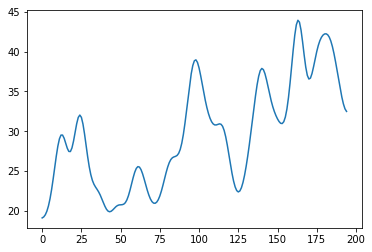

a grad norms [0.12101531, 0.121276006, 2.5933896e-05, 1.3502939e-05, 0.00021991014, 6.2181377e-10, 3.985545e-13]
v grad norms [2.8576682, 2.8545518, 4.7568554e-09, 1.2441047e-05]
c grad norms [0.0065691834, 0.0065694354, 6.599634e-09, 5.2006284e-09]
aloss 0.09279001 atype 1 closs 0.031392336 ctype 0 vloss 0.025780201 vtype 1
 ep,  210  avg frames 35.15
abs action (1,) 0.01569308526813984
max reward 1.0
 ep,  220  avg frames 35.1
abs action (1,) 0.01681382954120636
max reward 1.0
 ep,  230  avg frames 33.55
abs action (1,) 0.7488272449703606
max reward 1.0
a grad norms [0.13511306, 0.13524936, 7.1506496e-05, 8.805357e-06, 0.00010179327, 1.1339342e-10, 1.2174343e-11]
v grad norms [8.462029, 8.46079, 5.4901355e-09, 1.3332681e-05]
c grad norms [0.0014318653, 0.0014305668, 9.259541e-09, 4.531893e-09]
aloss 0.12059575 atype 1 closs 0.020750761 ctype 1 vloss 0.047704697 vtype 1
 ep,  240  avg frames 33.55
abs action (1,) 0.205826073884964
max reward 1.0
a grad norms [0.17095177, 0.17112885, 6

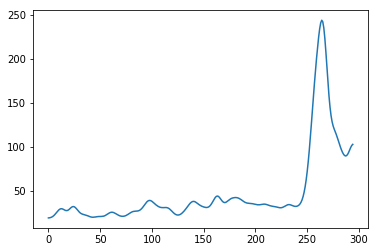

 ep,  310  avg frames 105.85
abs action (1,) 0.09532496333122253
max reward 1.0
a grad norms [0.048376113, 0.048386063, 6.057652e-06, 1.5778504e-07, 1.9532608e-06, 1.4193027e-10, 4.7059856e-12]
v grad norms [0.32443216, 0.32321173, 7.3405126e-09, 3.3464412e-06]
c grad norms [2.9915727e-05, 2.9513465e-05, 1.0724817e-08, 8.4798796e-10]
aloss 0.05823061 atype 1 closs 0.005315572 ctype 0 vloss 0.0083117485 vtype 1
 ep,  320  avg frames 108.2
abs action (1,) 0.15063737332820892
max reward 1.0
 ep,  330  avg frames 108.9
abs action (1,) 0.10245717316865921
max reward 1.0
a grad norms [0.06244363, 0.062447388, 3.1151158e-06, 8.0047954e-08, 2.1817748e-06, 1.9416063e-10, 2.1100788e-11]
v grad norms [0.22208613, 0.22140135, 7.1763204e-09, 2.5531438e-06]
c grad norms [2.3585188e-05, 2.3830768e-05, 1.0931127e-08, 6.4677047e-10]
aloss 0.016940057 atype 0 closs 0.0029295385 ctype 0 vloss 0.014327288 vtype 2
 ep,  340  avg frames 114.65
abs action (1,) 0.12435419857501984
max reward 1.0
 ep,  350  av

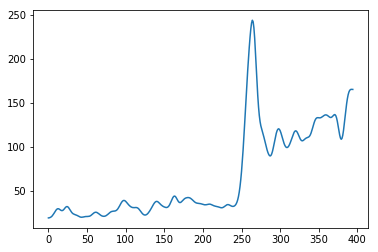

a grad norms [0.07130329, 0.071328074, 1.1661598e-05, 1.0625895e-06, 1.4639057e-05, 2.6155945e-11, 6.587667e-10]
v grad norms [1.2833787, 1.2809577, 7.294851e-09, 3.6263607e-06]
c grad norms [0.00043315653, 0.00043572776, 1.2518895e-08, 2.2774376e-09]
aloss 0.07487011 atype 2 closs 0.0020774007 ctype 1 vloss 0.0059814453 vtype 0
 ep,  410  avg frames 155.45
abs action (1,) 0.32809141278266907
max reward 1.0
a grad norms [0.05394921, 0.053959258, 5.751019e-06, 2.1219648e-07, 3.7906227e-06, 3.6176742e-11, 8.979398e-10]
v grad norms [1.6994634, 1.7007651, 6.9620723e-09, 3.0395522e-06]
c grad norms [0.0016528277, 0.0016574063, 1.1883069e-08, 2.0895068e-09]
aloss 0.08405435 atype 1 closs 0.006388366 ctype 0 vloss 0.021259308 vtype 2
 ep,  420  avg frames 122.05
abs action (1,) 0.21420158445835114
max reward 1.0
a grad norms [0.059613626, 0.059670072, 3.259258e-05, 1.5656286e-06, 2.0609457e-05, 4.1169134e-12, 5.7631266e-10]
v grad norms [0.2477138, 0.24592969, 7.092401e-09, 6.7363167e-06]
c 

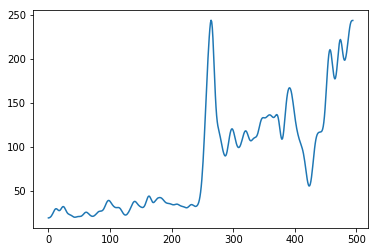

a grad norms [0.10645015, 0.10643955, 7.3838696e-06, 4.825565e-07, 1.803227e-05, 7.0469436e-11, 7.4861184e-10]
v grad norms [0.023816565, 0.023549555, 7.731872e-09, 3.8319877e-06]
c grad norms [6.127742e-05, 6.0466187e-05, 1.3309336e-08, 5.531057e-09]
aloss 0.10415417 atype 1 closs 0.007758528 ctype 2 vloss 0.01275444 vtype 2
 ep,  510  avg frames 246.55
abs action (1,) 0.279756098985672
max reward 1.0
a grad norms [0.119096756, 0.11909774, 3.883907e-05, 1.4728329e-07, 1.7638211e-05, 2.2386043e-11, 6.1270833e-10]
v grad norms [1.5886818, 1.5916492, 7.752414e-09, 4.1695453e-06]
c grad norms [2.0736463e-05, 2.0962489e-05, 1.3275084e-08, 7.2475674e-09]
aloss 0.01792854 atype 0 closs 0.002651006 ctype 1 vloss 0.012639999 vtype 1
 ep,  520  avg frames 232.05
abs action (1,) 0.13264407217502594
max reward 1.0
a grad norms [0.12963432, 0.12963746, 2.2668735e-05, 4.02314e-08, 7.7562845e-06, 2.1281789e-11, 2.6413716e-10]
v grad norms [0.79697645, 0.7935076, 7.723492e-09, 8.311556e-06]
c grad no

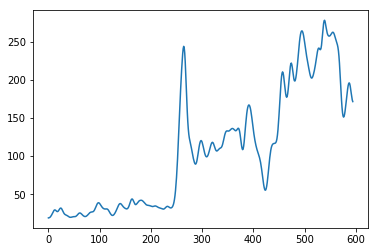

a grad norms [0.11318919, 0.11320441, 2.6744525e-05, 1.7020659e-07, 5.1363845e-06, 3.0690257e-12, 1.13791726e-10]
v grad norms [0.023534302, 0.023883061, 7.905591e-09, 4.5570723e-06]
c grad norms [2.6399399e-05, 2.6631622e-05, 1.1373107e-08, 2.339492e-08]
aloss 0.099179804 atype 2 closs 0.010176897 ctype 2 vloss 0.010529816 vtype 2
 ep,  610  avg frames 168.3
abs action (1,) 0.5006482601165771
max reward 1.0
a grad norms [0.13267042, 0.13267376, 2.0766138e-05, 1.2515588e-07, 3.837178e-06, 3.928604e-12, 8.508351e-11]
v grad norms [2.3973022, 2.3936157, 8.144865e-09, 3.5947169e-06]
c grad norms [1.8024739e-05, 1.8278392e-05, 1.0750908e-08, 1.5553699e-08]
aloss 0.12585449 atype 1 closs 0.0028691292 ctype 1 vloss 0.015812874 vtype 2
 ep,  620  avg frames 166.25
abs action (1,) 0.5021284222602844
max reward 1.0
a grad norms [0.10918025, 0.109199, 9.359727e-06, 6.38974e-07, 3.8427017e-05, 4.298893e-12, 1.7587515e-10]
v grad norms [0.2933343, 0.2944755, 7.895408e-09, 2.702353e-06]
c grad norm

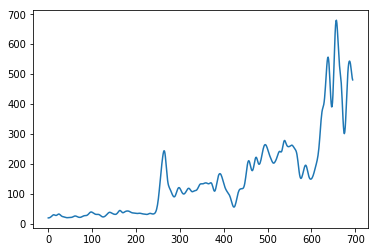

 ep,  710  avg frames 521.45
abs action (1,) 0.40519025921821594
max reward 1.0
a grad norms [0.66408634, 0.6640223, 1.2956832e-05, 3.1848984e-05, 7.732612e-05, 1.0925367e-11, 3.3312846e-11]
v grad norms [0.25806507, 0.2566049, 8.038566e-09, 5.2653577e-06]
c grad norms [0.00040830343, 0.0004072065, 8.930281e-09, 1.0711073e-08]
aloss 0.25040197 atype 1 closs 0.005157113 ctype 1 vloss 0.0026173592 vtype 0
 ep,  720  avg frames 554.3
abs action (1,) 0.00749854298557664
max reward 1.0
 ep,  730  avg frames 477.5
abs action (1,) 0.12521952390670776
max reward 1.0
a grad norms [0.6714232, 0.6714087, 0.00017513148, 1.2507708e-05, 5.5519104e-06, 3.3367946e-12, 1.5996855e-11]
v grad norms [0.7201198, 0.7212875, 8.014321e-09, 1.8873614e-05]
c grad norms [0.0039267936, 0.0039300057, 8.832173e-09, 1.6701428e-08]
aloss 0.020893693 atype 0 closs 0.018493056 ctype 1 vloss 0.022047997 vtype 1
 ep,  740  avg frames 489.6
abs action (1,) 0.2823631167411804
max reward 1.0
 ep,  750  avg frames 576.7
abs 

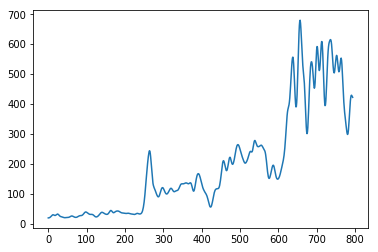

a grad norms [0.56113654, 0.5611965, 0.00044465542, 1.8848457e-05, 6.0254526e-05, 3.6252251e-12, 6.916961e-10]
v grad norms [2.5503964, 2.5535288, 7.99211e-09, 5.4609413e-06]
c grad norms [0.0026362909, 0.0026373835, 1.0056342e-08, 7.968148e-09]
aloss 0.014718294 atype 0 closs 0.0048577785 ctype 2 vloss 0.00498724 vtype 0
 ep,  810  avg frames 393.75
abs action (1,) 2.3856487572193146
max reward 1.0
a grad norms [0.60850173, 0.6085289, 0.00036149792, 7.634618e-06, 7.87219e-05, 3.6265667e-12, 1.613732e-09]
v grad norms [2.1638708, 2.1607788, 8.204394e-09, 3.8505377e-06]
c grad norms [0.0012366658, 0.0012350531, 1.03357e-08, 3.64403e-08]
aloss 0.2543335 atype 1 closs 0.0070800185 ctype 2 vloss 0.0064930916 vtype 2
 ep,  820  avg frames 433.5
abs action (1,) 0.18985678255558014
max reward 1.0
a grad norms [0.86998385, 0.87010187, 0.00050252373, 7.626948e-06, 0.00013649346, 1.7752083e-11, 5.1256666e-10]
v grad norms [3.4706788, 3.4737415, 8.101586e-09, 6.0543825e-06]
c grad norms [0.002035

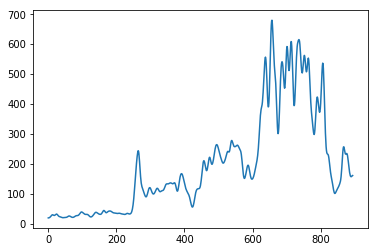

a grad norms [0.7133318, 0.7134402, 0.00022822605, 8.192143e-06, 3.7524398e-05, 5.326271e-11, 1.9657471e-09]
v grad norms [0.20409441, 0.20396894, 8.815961e-09, 1.0883976e-05]
c grad norms [0.00040635487, 0.0004065207, 1.1282866e-08, 5.2645444e-08]
aloss 0.017024219 atype 0 closs 0.0063655674 ctype 2 vloss 0.030180931 vtype 1
 ep,  910  avg frames 150.3
abs action (1,) 1.7308980524539948
max reward 1.0
a grad norms [0.6155079, 0.6155035, 7.684068e-05, 5.673774e-08, 6.664646e-05, 9.29054e-12, 4.3989218e-10]
v grad norms [0.20147508, 0.20081739, 9.0962775e-09, 6.6871235e-06]
c grad norms [0.0047025364, 0.004706198, 1.08448415e-08, 2.0171518e-08]
aloss 0.018105745 atype 0 closs 0.01268208 ctype 1 vloss 0.01008606 vtype 2
 ep,  920  avg frames 125.6
abs action (1,) 0.3213403820991516
max reward 1.0
a grad norms [0.6187656, 0.61893106, 0.00043509243, 8.6220185e-05, 5.9514286e-06, 1.68017e-11, 5.9972336e-07]
v grad norms [6.47796, 6.4795556, 8.974009e-09, 5.1267943e-06]
c grad norms [0.00203

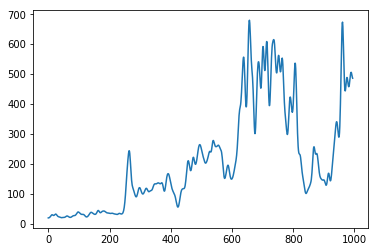

a grad norms [0.8370485, 0.8370337, 1.4398476e-05, 5.2439536e-06, 1.2094941e-05, 8.056909e-11, 6.829867e-11]
v grad norms [1.9988616, 1.998733, 9.450159e-09, 5.6390318e-06]
c grad norms [0.02512146, 0.025123084, 1.0935353e-08, 7.930332e-09]
aloss 0.010313988 atype 0 closs 0.0031026602 ctype 0 vloss 0.008794308 vtype 2
 ep,  1010  avg frames 628.1
abs action (1,) 0.4241105020046234
max reward 1.0
a grad norms [0.770309, 0.7702975, 3.3253877e-05, 9.811089e-06, 7.0698975e-06, 7.917174e-11, 2.234479e-07]
v grad norms [0.962796, 0.96190983, 9.579576e-09, 3.927286e-06]
c grad norms [0.004205814, 0.004203782, 1.1346711e-08, 7.881721e-08]
aloss 0.015582085 atype 0 closs 0.0030574799 ctype 0 vloss 0.011243343 vtype 1
 ep,  1020  avg frames 829.65
abs action (1,) 0.3252744543569007
max reward 1.0
 ep,  1030  avg frames 824.15
abs action (1,) 0.03812398761510849
max reward 1.0
 ep,  1040  avg frames 613.8
abs action (1,) 0.23727335035800934
max reward 1.0
a grad norms [0.83285064, 0.8328286, 8.57

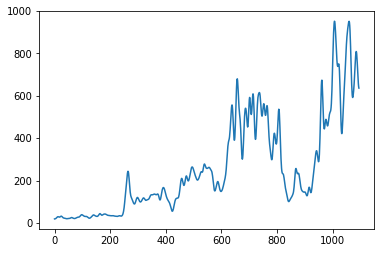

a grad norms [1.2131884, 1.213198, 0.00015114916, 1.0998068e-05, 9.1753995e-05, 3.4977344e-12, 2.2155687e-11]
v grad norms [1.7113276, 1.7095895, 9.658979e-09, 2.3121265e-06]
c grad norms [0.00011396281, 0.00011429899, 1.2046429e-08, 3.649376e-09]
aloss 0.010091424 atype 0 closs 0.0048070997 ctype 1 vloss 0.0035114288 vtype 0
 ep,  1110  avg frames 819.75
abs action (1,) 0.18843376636505127
max reward 1.0
a grad norms [1.1031606, 1.1032752, 1.4718029e-05, 7.409384e-05, 0.00012304947, 3.2890893e-12, 6.4711375e-11]
v grad norms [2.990657, 2.9888334, 9.751829e-09, 6.6929942e-06]
c grad norms [0.0011978914, 0.0011991678, 1.2198397e-08, 6.0896226e-09]
aloss 0.32616186 atype 1 closs 0.0031803846 ctype 2 vloss 0.016759872 vtype 2
 ep,  1120  avg frames 931.0
abs action (1,) 0.05026468262076378
max reward 1.0
 ep,  1130  avg frames 925.55
abs action (1,) 0.44078361988067627
max reward 1.0
a grad norms [1.3625872, 1.3626677, 2.2107117e-05, 7.6114535e-05, 7.8380406e-05, 2.9466544e-12, 9.66904e-1

In [ ]:
if trained:
    try:
        saver.restore(sess, tffile)
        with open(obj_fname, "rb") as f:
            ah, sh, mh, rh, rdecayedh, maskh, ep, globalframes = pickle.load(f)
        print('restored from save file')
    except:
        print('no save file detected')
MAX_SEQ_LEN = 5000
for ep in range(ep, 10000000):
    if ep % 100 == 0 and trained and ep > 0:
        save_path = saver.save(sess, tffile)
        print('saved at epoch', ep)
        with open(obj_fname,"wb") as f:
            pickle.dump(
                [ah[-1000:], sh[-1000:], mh[-1000:],
                 rh[-1000:], rdecayedh[-1000:], maskh[-1000:], ep, globalframes
                ], f)
    trained = 1
    ongoing = 1
    an, sn = [np.zeros((0, i)) for i in [N_ACT, INPUT_UNITS]]
    mn, rn, maskn = [], [], []
    frame = 0
    score = 0
    restart_delay = 5
    obs = env.reset()
    obs = np.concatenate((obs, np.zeros((N_ACT))))
    obs = np.concatenate((obs, np.zeros_like(obs)))
    obs_mat = np.concatenate((
        obs[None,:],np.zeros((NUM_HISTORY-1, N_STATE))), 0)
    done_ctr = 0
    metaobs = .00
    mn.append(metaobs)
    sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
    step_num = 0
    step_shifted = -1
    show_shift = 0
    while 1:
        prob_random = .95#1 - 1/np.sqrt(ep+1)
        step_num += 1
        a = pi.act(obs_mat.flatten(), metaobs, env)
        if step_shifted == -1: #always act on your own
            shifted = 1
            if np.random.rand() > prob_random:
                a = np.random.randn(*a.shape)*.01
            elif np.random.rand() > prob_random:
                a = a + np.random.randn(*a.shape) * .5
                #a = a + np.random.randn(*a.shape)/np.sqrt(np.sqrt(ep + 2))*4
            elif np.random.rand() > prob_random:
                impact = np.random.binomial(size=a.shape, n=1, p= 0.5) * 2
                if np.random.rand() > .5:
                    a = a + impact
                else:
                    a = a - impact
            elif np.random.rand() > prob_random:
                impact = np.random.binomial(size=a.shape, n=1, p= 0.5) * 2 - 1
                a = a + impact
            elif np.random.rand() > prob_random:
                a = a * .5
            elif np.random.rand() > prob_random:
                a = a * 2
            else:
                shifted = 0
            if shifted:
                step_shifted = step_num
            t = a
#         else:
#             if step_shifted > -1:
#                 if not show_shift:
#                     show_shift = 1
#                     print('step_shifted', step_shifted)
        an = np.concatenate((an, a[None,:]), 0)
        last_obs = obs
        obs, r, done, _ = env.step(a)
        obs = np.concatenate((obs, a))
        obs = np.concatenate((obs, obs - last_obs[:last_obs.shape[0]//2]))
        obs_mat = np.concatenate((obs[None,:], obs_mat[:-1,:]/1.3), 0)
        metaobs = metaobs + .01
        mn.append(metaobs)
        rn.append(r)
        sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
        score += r
        frame += 1
        still_open = env.render("human")
        if done:
            done_ctr += 1
            if done_ctr > 3:
                if ep % MAX_SEQ_LEN == 0:
                    print('score', score, ' frames', frame)
                break
        if still_open==False:
            crashhere
        if not done: continue
        if restart_delay==0:
            print("score=%0.2f in %i frames" % (score, frame))
            if still_open!=True:      # not True in multiplayer or non-Roboschool 
                break
            restart_delay = 2000*2  # 2 sec at 60 fps
        restart_delay -= 1
        if restart_delay==0: 
            break
    localframes.append(frame)
    rn = np.array(rn)
    rn[-1] = rn[-1] - 20
    rewards = [0]
    for ir in rn[::-1]:
        rewards.append(rewards[-1] * GAMMA + ir)
    rdecayedn = np.array(rewards)[:0:-1]
    lenrdec = len(rdecayedn)
#     rdecayedn = rdecayedn + lenrdec
#     rdecayedn = rdecayedn - np.arange(lenrdec) * 1.8
    mn = np.array(mn)
    maskn = np.ones_like(rn)
    if step_shifted > -1:
        if step_shifted == 0:
            raise ValueError('step shifted not allowed 0')
        maskn[:step_shifted - 1] = 0
    if ep == 0:
        ah, sh, mh, rh, rdecayedh, maskh = [
            np.expand_dims(v, 0) for v in [an, sn, mn, rn,rdecayedn, maskn]]
    else:
        def get_updated_h(h, n, third_dim):
            hshape = h.shape[1]
            nshape = n.shape[0]
            if third_dim:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape, n.shape[-1]))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((
                        h.shape[0], nshape - hshape, h.shape[-1]))), 1)
            else:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((h.shape[0], nshape - hshape))), 1)
            h = np.concatenate((h, np.expand_dims(n, 0)), 0)
            return h
            
        ah, sh = [get_updated_h(h, n, 1) for  h, n in zip([ah, sh], [an, sn])]
        
        mh, rh, rdecayedh, maskh = [
            get_updated_h(h, n, 0) for h, n in zip(
                [mh, rh, rdecayedh, maskh], [mn, rn, rdecayedn, maskn])]
        
    if ep % 1 == 0 and ep > 5:
        ah, sh, mh, rh,rdecayedh, maskh = [
            v[-400:] for v in [ah, sh, mh, rh,rdecayedh, maskh]]
        globalframes.append(np.mean(localframes))
        localframes = []
        batch_size = 16
        if ep < batch_size:
            batch_size = ep
        num_hist = ah.shape[0]
        total_aloss = 0
        total_closs = 0
        for itr in range(1):
            if num_hist >  batch_size:
                forced_hist = 2
                #probability = np.arange(num_hist - forced_hist)
                probability = num_steps_per_run = (
                    maskh.shape[1] - maskh[:,::-1].argmax(1))[:-forced_hist]
                probability = np.square(probability)
                probability = probability / probability.sum()
                samples = np.concatenate((
                    np.random.choice(
                        num_hist - forced_hist, batch_size - forced_hist, 
                        replace=False, p=probability),
                    np.arange(
                        num_hist - forced_hist, num_hist)))
            else:
                samples = np.random.choice(num_hist, num_hist, replace=False)
            actions, states, meta, returns, returnsdecayed, mask = [
                v[samples] for v in [ah, sh, mh, rh,rdecayedh, maskh]]
            feed_dict={
                        self.metaobs:meta[:,:,None],
                        self.returns:returns,
                        self.returnsdecayed:returnsdecayed,
                        self.lr: .05 / np.power(ep + 10, .5),
                        self.mask:mask}
            if ADV_ENABLED:
                adv_sample = np.random.rand() > .3
            else:
                adv_sample = 0
            if adv_sample:
                a_type = np.random.choice(3)
                feed_dict[self.obs] = states
                a_obs_grad, aloss_pre = sess.run(
                    [self.a_obs_grad, self.a_loss], feed_dict)
                a_obs_grad = normalize_adv(a_obs_grad[0], mag = 3, adv_type = a_type)
                feed_dict[self.obs] = states + a_obs_grad
            else:
                feed_dict[self.obs] = states + np.random.rand(*states.shape) * .1
            _, aloss = sess.run(
                [self.aopt, self.a_loss],
                feed_dict = feed_dict
                    )
            if TESTING_GRAD_NORMS and ep % 10 == 0 and adv_sample:
                a_grad_norms = self.sess.run(self.a_grads, feed_dict)
                print('a grad norms', a_grad_norms)
            if adv_sample:
                feed_dict[self.pi] = actions
                feed_dict[self.obs] = states[:,:-1,:]
            else:
                feed_dict[self.pi] = actions + np.random.rand(*actions.shape) * .1
                feed_dict[self.obs] = states[:,:-1,:] + np.random.rand(
                    *states[:,:-1,:].shape) * .1
            feed_dict[self.metaobs] = meta[:,:-1,None]
            feed_dict[self.returns] = returns[:,:-1]
            feed_dict[self.returnsdecayed] = returnsdecayed[:,:-1]
            feed_dict[self.mask] = mask[:,:-1]
            if adv_sample:
                feed_dict[self.pi] = actions
                feed_dict[self.obs] = states[:,:-1,:]
                v_obs_grad, vloss_pre = sess.run(
                    [self.v_obs_grad, self.v_loss], feed_dict)
                v_type = np.random.choice(3)
                v_obs_grad = normalize_adv(v_obs_grad[0], mag = .1, adv_type = v_type)
                feed_dict[self.obs] = states[:,:-1,:] + v_obs_grad
                _, vloss = sess.run(
                    [self.vopt, self.v_loss],
                        feed_dict=feed_dict)
                if TESTING_GRAD_NORMS and ep % 10 == 0:
                    v_grad_norms = self.sess.run(self.v_grads, feed_dict)
                    print('v grad norms', v_grad_norms)
                
                feed_dict[self.pi] = actions
                feed_dict[self.obs] = states[:,:-1,:]
                c_obs_grad, c_pi_grad, closs_pre = sess.run(
                    [self.c_obs_grad, self.c_pi_grad, self.c_loss], feed_dict)
                c_type = np.random.choice(3)
                c_obs_grad, c_pi_grad = [
                    normalize_adv(v[0], mag = .1, adv_type = c_type) 
                    for v in [c_obs_grad, c_pi_grad]]
                feed_dict[self.pi] = actions + c_pi_grad
                feed_dict[self.obs] = states[:,:-1,:] + c_obs_grad
                
                _,closs = sess.run(
                    [self.copt, self.c_loss],
                        feed_dict=feed_dict)
                if TESTING_GRAD_NORMS and ep % 10 == 0:
                    c_grad_norms = self.sess.run(self.c_grads, feed_dict)
                    print('c grad norms', c_grad_norms)
                
            else:
                _,_, closs, vloss = sess.run(
                    [self.copt,self.vopt, self.c_loss, self.v_loss],
                        feed_dict=feed_dict)
            if 0:
                if ep % 10 == 0:('aloss', aloss, 'closs', closs, 'vloss', vloss)
        if ep % 10 == 0:
            if adv_sample:
                print('aloss', aloss - aloss_pre, 'atype', a_type,
                      'closs', closs - closs_pre,  'ctype', c_type,
                      'vloss', vloss - vloss_pre,  'vtype', v_type,)
            print(' ep, ', ep, ' avg frames',np.mean(globalframes[-20:]))
            print('abs action',np.abs(ah)[-1,0,:].shape, np.abs(ah)[-1,0,:].mean())
            print('max reward',np.max(rh[-10:,10:]))
        if ep % 10000 == 0:
            clear_output()
        if ep % 100 == 0:
            ysmoothed = gaussian_filter1d(globalframes, sigma=4)
            plt.plot(ysmoothed)
            plt.show()


In [ ]:
ah[-1]

In [ ]:
samples = np.arange(
            num_hist - 4, num_hist)
actions, states, meta, returns, returnsdecayed, mask = [
    v[samples] for v in [ah, sh, mh, rh,rdecayedh, maskh]]
feed_dict={
            self.metaobs:meta[:,:,None],
            self.returns:returns,
            self.returnsdecayed:returnsdecayed,
            self.lr: .01 / np.power(ep + 10, .7),
            self.mask:mask,
            self.obs:states}

In [ ]:
# sess.run(tf.global_variables_initializer())

In [ ]:
# self.sess.run(self.pi, feed_dict)[3]

In [ ]:
ah[-4].std()

In [ ]:
self.sess.run(self.actstdpenalty, feed_dict)

In [ ]:
ah[-8].std()

In [ ]:
self.sess.run(self.pi, feed_dict)[-4]

In [ ]:

        self.a_grads = [
            get_grad_norm(self.actor_opt, l) for l in [
            self.a_loss_minimize, self.a_loss_raw, self.aregmagnitude, self.aregmean,
            self.actstdpenalty, self.areg, self.grad_norm_a
        ]]
        self.v_grads = [get_grad_norm(self.value_opt, l) for l in [
            self.v_loss_minimize, self.v_loss_raw, self.vreg, self.grad_norm_v
        ]]
        self.c_grads = [get_grad_norm(self.critic_opt, l) for l in [
            self.c_loss_minimize, self.c_loss_raw, self.creg, self.grad_norm_c
        ]]
        

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

ysmoothed = gaussian_filter1d(globalframes, sigma=4)
plt.plot(ysmoothed)

In [ ]:

save_path = saver.save(sess, tffile)
print('saved at epoch', ep)
with open(obj_fname,"wb") as f:
    pickle.dump(
        [ah[-1000:], sh[-1000:], mh[-1000:],
         rh[-1000:], rdecayedh[-1000:], maskh[-1000:], ep, globalframes
        ], f)
trained = 1

In [ ]:
# rdecayedh[-2][np.where(mask[2])]

# sess.run(self.state_value_estimate,feed_dict)[2][np.where(mask[2])]

In [ ]:
# sess.run(self.state_value_estimate,feed_dict)[1][np.where(mask[1])].shape

# sess.run(self.state_value_estimate,feed_dict)[1][np.where(mask[1])]

In [ ]:
ah[-2][:5].round(2)